# LGBM Inference

In [106]:
import pandas as pd
import os
import random
import math
from tqdm import tqdm
import numpy as np
import time

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch

## 데이터 로드

In [107]:
# 성능 제일 좋았던 것에서 델타 새로하고 상대누적값 추가 - 5천 돌렸을때 가장 높은 성능
train = pd.read_csv('/opt/ml/network/new_train.csv')

In [108]:
train

,userID,KnowledgeTag,assessmentItemID,testId,grade,answerCode,elapsed,Timestamp,hour,dow,...,left_asymptote,elo_prob,answer_delta,tag_delta,test_delta,assess_delta,prior_relative_assess_ac_sum,prior_relative_answer_ac_sum,prior_relative_tag_ac_sum,prior_relative_test_ac_sum
0,aaa,0,33,싸이,0,1,0.000,2021-06-20 09:58:48.596,9,6,...,0,0.894410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,aaa,0,35,싸이,0,1,3.443,2021-06-20 09:58:52.039,9,6,...,0,0.821841,0.205882,0.205882,0.000000,0.000000,0.000000,0.205882,0.205882,0.000000
2,aaa,0,19,무한도전,1,1,2.453,2021-06-20 09:58:54.492,9,6,...,0,0.587987,0.205882,0.428571,0.000000,0.000000,0.000000,0.411765,0.634454,0.000000
3,aaa,0,12,마동석,0,1,2.890,2021-06-20 09:58:57.382,9,6,...,0,0.812202,0.428571,0.500000,0.000000,0.666667,0.666667,0.840336,1.134454,0.000000
4,aaa,0,18,소녀시대,0,1,2.195,2021-06-20 09:58:59.577,9,6,...,0,0.807982,0.205882,0.205882,0.000000,0.000000,0.666667,1.046218,1.340336,0.000000
5,aaa,0,37,EXO,1,1,2.890,2021-06-20 09:59:02.467,9,6,...,0,0.842355,0.205882,0.428571,0.500000,0.000000,0.666667,1.252101,1.768908,0.500000
6,aaa,0,39,무한도전,0,1,2.385,2021-06-20 09:59:04.852,9,6,...,0,0.672346,0.428571,0.500000,0.666667,0.250000,0.916667,1.680672,2.268908,1.166667
7,aaa,0,28,소녀시대,1,1,2.824,2021-06-20 09:59:07.676,9,6,...,0,0.779449,0.205882,0.205882,0.000000,0.500000,1.416667,1.886555,2.474790,1.166667
8,aaa,0,21,EXO,0,1,3.016,2021-06-20 09:59:10.692,9,6,...,0,0.769037,0.428571,0.428571,0.250000,0.333333,1.750000,2.315126,2.903361,1.416667
9,aaa,0,22,소녀시대,0,1,3.532,2021-06-20 09:59:14.224,9,6,...,0,0.851828,0.205882,0.500000,0.250000,0.333333,2.083333,2.521008,3.403361,1.666667


In [76]:
# train = pd.concat([train, train]).reset_index(drop = True)

## 카테고리 피쳐 라벨링

In [109]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_feats = ['grade']
label_feats = ['problem_number','solved_disorder','KnowledgeTag','testId','retest']
        
# 'problem_number','grade', 'testId','KnowledgeTag','problem_count','type_count','solved_disorder'

for c in ordinal_feats :
    X = train[c].values.reshape(-1,1)
    enc = OrdinalEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X
    
for c in label_feats :
    X = train[c].values.reshape(-1,1)
    enc = LabelEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [110]:
# 사용할 Feature 설정

FEATS = [
    'last_problem', 
    'KnowledgeTag', 'assessmentItemID', 'testId', 'grade','elapsed',
    'prior_KnowledgeTag_frequency','retest',
       'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'elo_prob',
    
        'tag_delta', 'answer_delta', 'test_delta', 'assess_delta',
        'prior_relative_assess_ac_sum', 'prior_relative_answer_ac_sum',
       'prior_relative_tag_ac_sum', 'prior_relative_test_ac_sum',    
       'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'tag_elp', 'tag_elp_o',
       'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp',
       'prb_elp_o', 'prb_elp_x', 'user_correct_answer', 'user_total_answer',
       'user_acc', 'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp',
       'GradeMElp', 'problem_count', 'tag_count',
       'problem_position', 'solve_order', 'solved_disorder'
]

len(FEATS)


48

In [111]:
y_train = train['answerCode']
train = train.drop(['answerCode'], axis = 1)

In [112]:
lgb_train = lgb.Dataset(train[FEATS], y_train)

## 4. 훈련 및 검증

In [ ]:
# 추가 학습
train_again = lgb.train(
                    {'objective': 'binary','metric':'auc', 'boosting' :'dart'},
                    lgb_train,
                    num_boost_round=1000)

train_again.save_model('/opt/ml/network/lgbm_first_model.txt')

In [114]:
tt = train_again.predict(train[FEATS])

In [115]:
tt

array([0.95376026, 0.86053033, 0.97255051, 0.99518916, 0.99815614,
       0.99372442, 0.99901488, 0.99345755, 0.88552529, 0.89942135,
       0.9819012 , 0.57472935, 0.94778646, 0.99303112, 0.79547678,
       0.2831254 , 0.99859695, 0.05099256, 0.00918053, 0.99317307,
       0.99624654, 0.18760634, 0.99483026, 0.97069449, 0.99309659,
       0.03757412, 0.93756971, 0.99926697, 0.99589187, 0.03687114,
       0.9819012 , 0.96423707, 0.99020369, 0.22516105, 0.2623593 ,
       0.99595608, 0.9212851 , 0.98461579, 0.07005372, 0.91809552,
       0.97645214, 0.57139638, 0.98932307, 0.72759762, 0.03687114,
       0.08292303, 0.05389106, 0.8494515 , 0.9793357 , 0.07877987])

In [49]:
y_train

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    0
12    1
13    1
14    1
15    0
16    1
17    0
18    0
19    1
20    1
21    0
22    1
23    1
24    1
25    0
26    1
27    1
28    1
29    0
30    1
31    1
32    1
33    0
34    0
35    1
36    1
37    1
38    0
39    1
40    1
41    1
42    1
43    1
44    0
45    0
46    0
47    1
48    1
49    0
Name: answerCode, dtype: int64

In [52]:

output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "valid_0.005.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(valid_001):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/valid_0.005.csv


In [43]:
# MAKE PREDICTION
total_preds = model_005.predict(test[FEATS])

output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM_all_modified_features_with_testset_tuning_0.05 (dart).csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM_all_modified_features_with_testset_tuning_0.05 (dart).csv


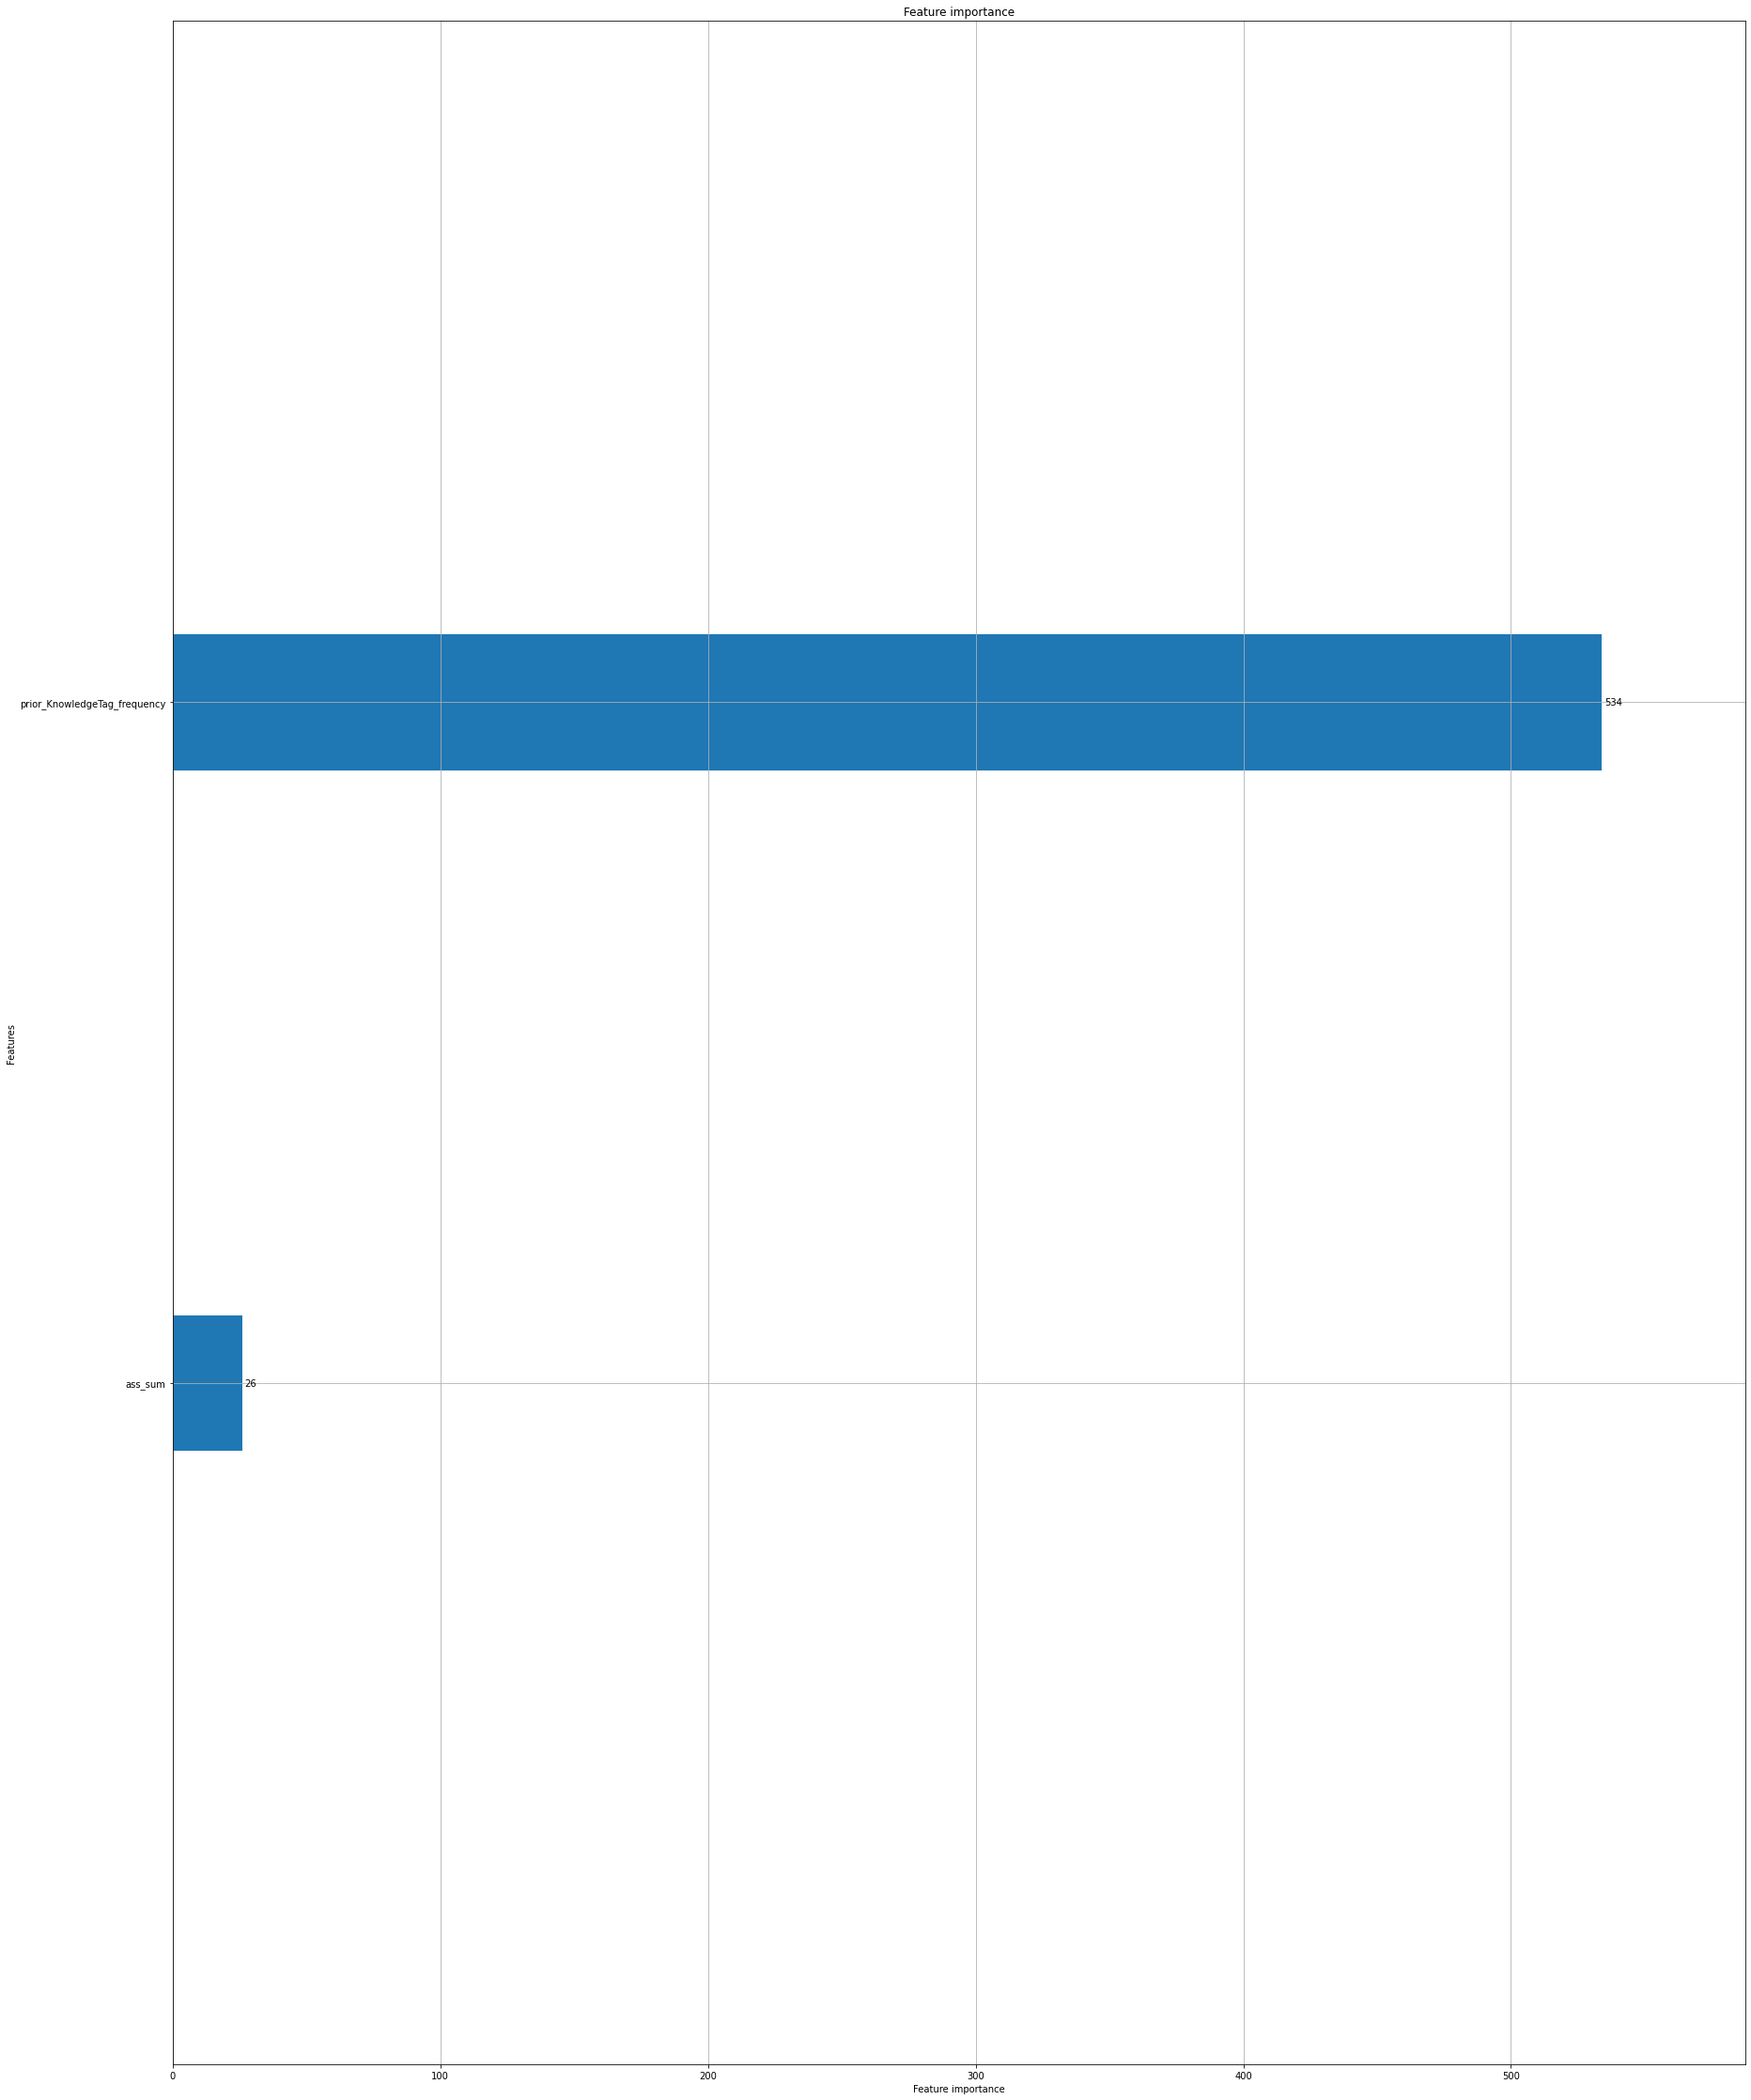

In [20]:
# 이어서한 모델 피쳐임포턴스
ax = lgb.plot_importance(train_again)
fig = ax.figure
fig.set_size_inches(30, 40)

## Inference

In [40]:
# MAKE PREDICTION
total_preds = train_again.predict(test[FEATS])

output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM_all_modified_features_with_testset_tuning_0.005 (dart).csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM_all_modified_features_with_testset_tuning_0.005 (dart).csv


In [29]:
total_preds

array([5.53323431e-01, 6.98342663e-01, 2.27920330e-01, 7.43415181e-01,
       2.93928153e-01, 9.00562665e-01, 6.41420636e-02, 2.21614584e-01,
       1.80282028e-01, 4.27963891e-01, 3.80728883e-01, 2.74545561e-01,
       9.39106817e-01, 9.39843071e-02, 5.22586519e-01, 9.59074904e-01,
       1.93829982e-01, 8.62838530e-01, 9.32416558e-01, 2.20980116e-01,
       9.52442350e-01, 5.96996495e-01, 6.77220553e-01, 1.39556023e-01,
       2.28608914e-01, 7.17761202e-01, 9.23206885e-01, 9.22213797e-01,
       5.15758468e-01, 8.01542059e-01, 7.64913664e-01, 6.49465489e-01,
       7.48040784e-01, 1.01918183e-01, 8.93782916e-01, 9.07662590e-01,
       1.58884070e-01, 6.15126971e-01, 3.16535327e-01, 1.38049166e-01,
       5.81155479e-01, 1.14493739e-01, 1.91464286e-01, 3.11414187e-01,
       6.75778361e-01, 8.46113646e-01, 5.69013736e-01, 2.41150400e-01,
       9.49967948e-01, 6.72331874e-01, 7.30617196e-01, 2.64802132e-01,
       3.45797029e-01, 1.14883357e-01, 3.71753322e-01, 7.37952487e-01,
      